In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from HelperFunctions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)


In [2]:
# train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
test_path = 'Data/test_catvnoncat.h5'
train_path = 'Data/train_catvnoncat.h5'


# loading test data from h5 file 
with h5py.File(test_path, 'r') as h5file:
    print("Keys in the test file:", list(h5file.keys()))
    
    test_x_orig = h5file['test_set_x'][:]
    test_y = h5file['test_set_y'][:]
    classes = h5file['list_classes'][:]
    
    print("Shape of test_x:", test_x_orig.shape)
    print("Shape of test_y:", test_y.shape)
    
with h5py.File(train_path, 'r') as h5file:
    print("Keys in the train file:", list(h5file.keys()))
    
    train_x_orig = h5file['train_set_x'][:]
    train_y = h5file['train_set_y'][:]
    
    print("Shape of train_x_orig:", train_x_orig.shape)
    print("Shape of train_y_orig:", train_y.shape)

Keys in the test file: ['list_classes', 'test_set_x', 'test_set_y']
Shape of test_x: (50, 64, 64, 3)
Shape of test_y: (50,)
Keys in the train file: ['list_classes', 'train_set_x', 'train_set_y']
Shape of train_x_orig: (209, 64, 64, 3)
Shape of train_y_orig: (209,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

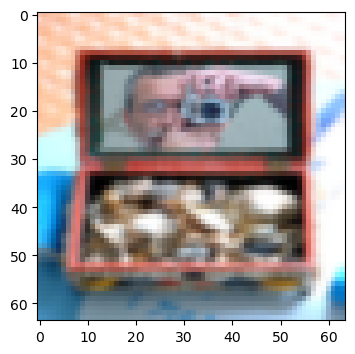

In [3]:
# Example of a picture
index = 15
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
#exploring the dataset

m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

# reshaping to make 2d array instead of vector
train_y = train_y.reshape(1, 209) 
test_y = test_y.reshape(1, 50)

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [5]:
# Reshape the training and the test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# standardize data to have feature values between 0 and 1
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [34]:
# constants for the neural net

n_x = 12288   # neurons in input layer
n_h = 7     # neurons in hidden layer
n_y = 1       # neurons in output layer
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [35]:
# two layer model function that I will use as reference for the L layer model function

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, b2
    
    """
    
    np.random.seed(2)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the helper functions
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(0, num_iterations):
        
        # Forward Prop
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        # computing cost
        
        cost = compute_cost(A2, Y)
        
        # initializing back prop
        
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        # setting grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'], to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # update parameters
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # get W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # print the cost every 100 iterations
        
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
            
    return parameters, costs

def plot_costs(costs, learning_rate = 0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
        
        
        
    


In [36]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))



{'W1': array([[ 0.01624345, -0.00611756, -0.00528172, ..., -0.00527214,
        -0.0038034 ,  0.00949412],
       [ 0.01009231,  0.00229889, -0.00664099, ...,  0.00689859,
        -0.00488322,  0.0020761 ],
       [-0.0035634 , -0.00195481,  0.00636803, ...,  0.00822751,
        -0.00104425, -0.00657957],
       ...,
       [-0.00315398,  0.0124543 , -0.01304592, ...,  0.00370126,
         0.01033177, -0.00896044],
       [ 0.00487913,  0.00350058, -0.00084749, ..., -0.00559281,
         0.00325022,  0.00231429],
       [ 0.00534074,  0.02512388, -0.01044755, ...,  0.0216518 ,
        -0.00842579,  0.00359795]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[-8.53306509e-03,  2.62677554e-02,  1.44462274e-03,
         2.81582154e-02, -4.48247037e-05,  1.56583537e-02,
        -2.90084643e-03]]), 'b2': array([[0.]])}
Cost after iteration 1: 0.6926114346158594
Cost after first iteration: 0.693049735659989


Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203889
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.27491377282130197
Cost after iteration 1300: 0.24681768210614827
Cost after iteration 1400: 0.19850735037466102
Cost after iteration 1500: 0.17448318112556646
Cost after iteration 1600: 0.17080762978096403
Cost after iteration 1700: 0.11306524562164721
Cost after iteration 1800: 0.09629426845937147
Cost after iteration 1900: 0.08342617959726861
Cost after iteration 2000: 0.07439078704319081
Cost after iteration 2100: 0.066307481

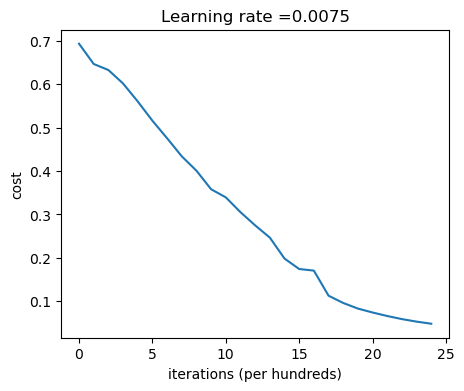

In [25]:
#training the model

parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost = True)
plot_costs(costs, learning_rate)

In [26]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


In [27]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


In [64]:
# L-layer neural network implementation

layers_dims = [12288, 20, 7, 5, 1] # 4-layer model

In [65]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    """
    Implements a L-layer neural network: [LINEAR->RELU] * (L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape(n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict. 
    
    """
    
    np.random.seed(1)
    
    costs = []
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        
        # forward prop for linear->relu * (L-1) then linear->sigmoid
        AL, caches = L_model_forward(X, parameters)
        
        # computing the cost
        cost = compute_cost(AL, Y)
        
        # back prop
        grads = L_model_backward(AL, Y, caches)
        
        # update params
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # so i can print cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
            
    return parameters, costs

In [66]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 1, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))

#L_layer_model_test(L_layer_model)

Cost after iteration 0: 0.7717493284237686
Cost after first iteration: 0.7717493284237686


In [67]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822913
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.567047326836611
Cost after iteration 500: 0.5401376634547801
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.46547737717668525
Cost after iteration 800: 0.369125852495928
Cost after iteration 900: 0.39174697434805344
Cost after iteration 1000: 0.3151869888600617
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268131
Cost after iteration 1300: 0.19960120532208644
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.16118854665827748
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.1377748781297294
Cost after iteration 1800: 0.1297401754919012
Cost after iteration 1900: 0.12122535068005211
Cost after iteration 2000: 0.1138206066863371
Cost after iteration 2100: 0.10783928526

In [58]:
pred_train = predict(train_x, train_y, parameters)


Accuracy: 0.9856459330143541


In [59]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8
